In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simplemd

### 1. Perform a simulation of a Lennard-Jones crystal with $864$ particles.

Temperature should be controlled using the Langevin thermostat at temperature $T=2$. Try with different values of the friction $\gamma$ (e.g. $0.01$, $0.1$, $1.0$) and look at the difference in the behavior of the potential energy.

The Langevin thermostat is given by,


In [7]:
cell, positions = simplemd.generate_lattice(6) # for 4n^3 = 864, n = 6

# Lennard-Jones units
print(positions.shape)
print(cell)

(864, 3)
(10.0776, 10.0776, 10.0776)


In [18]:
# no initial coordinates; Bussi code
frictions=[0.01,0.1,1.,10.,100.]
keys={
'temperature': 2,
'tstep': 0.005,
'forcecutoff': 2.5,
'listcutoff': 3.0,
'nstep': 10000,
'nconfig': 100,
'nstat': 10,
}

runners = []
for i in range(len(frictions)):
    keys["friction"]=frictions[i]
    keys["cell"]=cell
    keys["positions"]=positions.copy() # re-evolving 
    runners.append(simplemd.SimpleMD(**keys)) # create len(friction) runners

GPU Things
* Run on different/separate processes
* Python pickles processes, but has a problem
* Probably a `numba` issue

How to compute collision time
* velocity autocorrelation time
$$f(\tau)= \langle v_i(t)v_i(t+\tau)\rangle_t $$

$$\frac{f(\tau)}{f(0)}$$
* ~review
* decaying exponential (ish)
* average time that the velocity forgets its value 
* can show with different values of $\gamma$
* scales around $\frac{1}{\gamma}$

Checking equilibration
* Decide what you want to compute
* Do block analysis
* Typically, ideal equil time is different for different properties 

In [19]:
for r in runners:
    r.run()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 983.05it/s]


$\gamma=100$ becomes slower equilibration (not showing), because there are now more collisions with the bath than with the particles (check).

Text(0.5, 0, 'time')

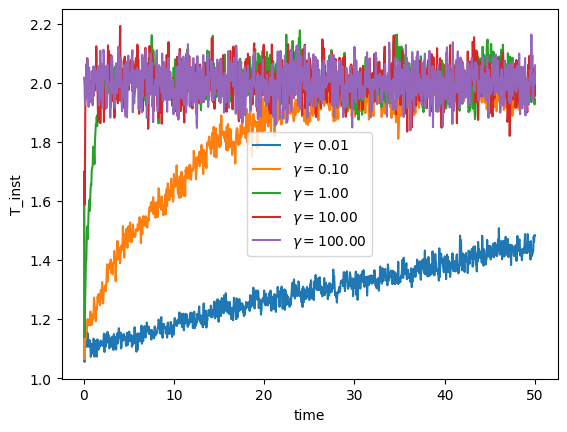

In [22]:
for i in range(len(frictions)):
    ene=np.array(runners[i].statistics)[:,3] # potential energy
    temp=np.array(runners[i].statistics)[:,2] # temperature
    time=np.array(runners[i].statistics)[:,1]
    # plt.plot(time,ene,label=str(frictions[i]))
    plt.plot(time,temp,label=r'$\gamma =$%.2f'%frictions[i])
plt.legend()
plt.ylabel("T_inst")
plt.xlabel("time")

### 2. Compute the average potential energy for different values of the temperature...

(ranging from $0.1$ to $3$ in Lennard Jones units) using a fixed friction (e.g. $\gamma=1$). Also compute the specific heat using energy fluctuations and look at how the specific heat depends on the temperature. Remember that you should discard the initial equilibration. 

Should have some transition happening around $T\sim 0.6$

In [24]:
Tlist=[0.1,0.3,0.5,0.6,0.7,0.8,1.,2.,3.]
# no initial coordinates; Bussi code
# frictions=[0.01,0.1,1.,10.,100.]
keys={
# 'temperature': 2,
'tstep': 0.005,
'forcecutoff': 2.5,
'listcutoff': 3.0,
'nstep': 10000,
'nconfig': 100,
'nstat': 10,
'friction':10
}

runners = []
for i in range(len(Tlist)):
    keys["temperature"]=Tlist[i]
    keys["cell"]=cell
    keys["positions"]=positions.copy() # re-evolving 
    runners.append(simplemd.SimpleMD(**keys)) # create len(friction) runners

In [25]:
for r in runners:
    r.run()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 812.08it/s]


Useful command:
* `screen`
    * Runs even while disconnected
* `tmux`  
    * More or less the same

Plots
* Review latent heat
* Heat capacity

Text(0.5, 0, 'time')

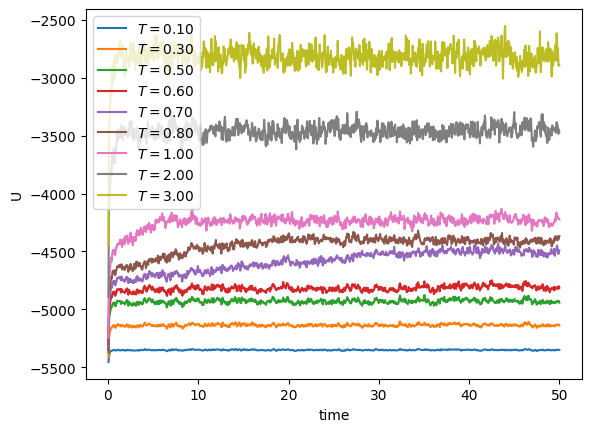

In [29]:
for i in range(len(Tlist)):
    ene=np.array(runners[i].statistics)[:,3] # potential energy
    temp=np.array(runners[i].statistics)[:,2] # temperature
    time=np.array(runners[i].statistics)[:,1]
    # plt.plot(time,ene,label=str(frictions[i]))
    plt.plot(time,ene,label=r'$T=$%.2f'%Tlist[i])
plt.legend()
plt.ylabel("U")
plt.xlabel("time")

Latent heat discussion 

In [31]:
U=[]
C=[]
for i in range(len(Tlist)):
    ene=np.array(runners[i].statistics)[:,3]
    ene = ene[len(ene)//2:]
    U.append(np.average(ene))
    C.append(np.var(ene)/Tlist[i]**2)
U = np.array(U)
C = np.array(C)

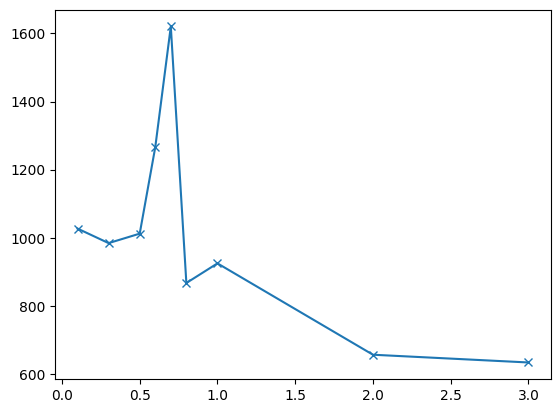

In [33]:
plt.plot(Tlist,C,"x-")

Peak calculated from... (review)

In [35]:
864 * 3 * 0.5 # SHO values; has significant anharmonic effects 

1296.0

In [43]:
Tlist=np.array(Tlist)

ValueError: x and y must have same first dimension, but have shapes (9,) and (8,)

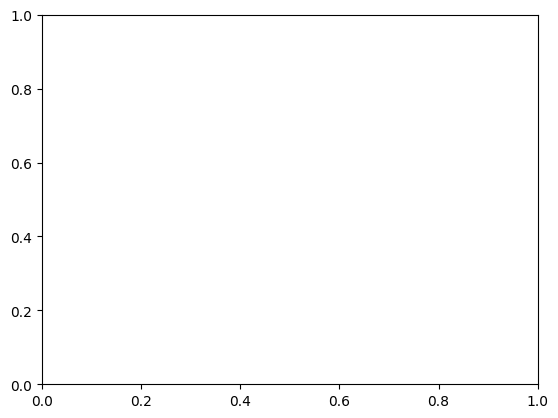

In [44]:
Cdiff = (U[1:]-U[:-1])/(Tlist[1:]-Tlist[:-1]) # dU/dT estimate
plt.plot(Tlist,Cdiff,"x-")
plt.plot(0.5*(Tlist[:-1]+Tlist[1:]),Cdiff,"x-") # check code again 

In [ ]:
for i in range(len(Tlist)):
    ene=np.array(runners[i].statistics)[:,3] # potential energy
    temp=np.array(runners[i].statistics)[:,2] # temperature
    time=np.array(runners[i].statistics)[:,1]
    # plt.plot(time,ene,label=str(frictions[i]))
    plt.plot(time,temp,label=r'$\gamma =$%.2f'%Tlist[i])
plt.legend()
plt.ylabel("T_inst")
plt.xlabel("time")

### 3. Repeat the same calculation but starting from a structure that has been equilibrated for a long time at temperature $T=3$.

(hint: `simplemd` writes the final coordinates on a file, you should restart from that configuration). Are the value of average and fluctuations of $U$ equal or diferent with respect to previous points? For which values of $T$ do you observe more difference?

In [45]:
Tlist=[0.1,0.3,0.5,0.6,0.7,0.8,1.,2.,3.]
# no initial coordinates; Bussi code
# frictions=[0.01,0.1,1.,10.,100.]
keys={
# 'temperature': 2,
'tstep': 0.005,
'forcecutoff': 2.5,
'listcutoff': 3.0,
'nstep': 10000,
'nconfig': 100,
'nstat': 10,
'friction':10
}

runners_cooling = []
for i in range(len(Tlist)):
    keys["temperature"]=Tlist[i]
    keys["cell"]=runners[-1].output[0] # nth state of the last runner; output0 final cellsize; output1 - positions
    keys["positions"]=runners[-1].output[1] # re-evolving 
    runners_cooling.append(simplemd.SimpleMD(**keys)) # create len(friction) runners

In [46]:
for r in runners_cooling:
    r.run()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 807.37it/s]


Review
* hysteresis (system remembers that it was a liquid)

In [ ]:
runners_cooling

### 4. At fixed $T=1$, look at how the heat capacity depends on system size...

(try e.g. $256$, $500$, and $864$ particles).

Expectation
* Heat capacity increases proportionally with the system size
* Redo

### 5. Modify the routine thermostat() so as to implement velocity rescaling.

Compute average and fluctuations at fixed $T$ and compare with results obtained with Langevin thermostat.

In [ ]:
import numpy as np
import re
import numba
import tempfile
import sys

try:
    from tqdm import tqdm
except ModuleNotFoundError:
    def tqdm(a):
        return a

# Random number generator compatible with C++ and FORTRAN versions

_IA=16807
_IM=2147483647
_IQ=127773
_IR=2836
_NTAB=32
_NDIV=(1+(_IM-1)//_NTAB)
_EPS=3.0e-16
_AM=1.0/_IM
_RNMX=(1.0-_EPS)

@numba.njit(cache=True,fastmath=True)
def _U01(idum,iy,iv):
    if idum <= 0 or iy == 0:
        if (-idum < 1):
            idum=1
        else:
            idum=-idum
        for j in range(_NTAB+7,-1,-1):
            k=idum//_IQ
            idum=_IA*(idum-k*_IQ)-_IR*k
            if idum<0:
                idum += _IM
            if j < _NTAB:
                iv[j] = idum
        iy=iv[0]
    k=idum//_IQ
    idum=_IA*(idum-k*_IQ)-_IR*k
    if idum<0:
        idum += _IM
    j=iy//_NDIV
    iy=iv[j]
    iv[j]=idum
    temp=_AM*iy
    if temp > _RNMX:
        temp = _RNMX
    return idum,iy,temp

@numba.njit(cache=True,fastmath=True)
def _U01_loop(idum,iy,iv,numbers):
    for i in range(len(numbers)):
        idum,iy,numbers[i] = _U01(idum,iy,iv)
    return idum,iy

@numba.njit(cache=True,fastmath=True)
def _Gaussian(idum,iy,iv,switchGaussian,saveGaussian):
    if(switchGaussian):
        return idum,iy,False,0.0,saveGaussian
    else:
        while True:
            idum,iy,r1=_U01(idum,iy,iv)
            idum,iy,r2=_U01(idum,iy,iv)
            v1=2.0*r1-1.0
            v2=2.0*r2-1.0
            rsq=v1*v1+v2*v2
            if(rsq<1.0 and rsq>0.0):
                break
        fac=np.sqrt(-2.0*np.log(rsq)/rsq)
        return idum,iy,True,v1*fac,v2*fac

@numba.njit(cache=True,fastmath=True)
def _Gaussian_loop(idum,iy,iv,switchGaussian,saveGaussian,numbers):
    for i in range(len(numbers)):
        idum,iy,switchGaussian,saveGaussian,numbers[i] = _Gaussian(
            idum,iy,iv,switchGaussian,saveGaussian
    )
    return idum,iy,switchGaussian,saveGaussian

class Random():
    def __init__(self,seed=0):
        self.switchGaussian=False
        self.saveGaussian=0.0
        self.iy=0
        self.iv=np.zeros(_NTAB, dtype=int)
        self.idum=0
        self.idum=seed
    def U01(self,shape=None):
        if shape is None:
            self.idum,self.iy,temp = _U01(self.idum,self.iy,self.iv)
            return temp
        else:
            numbers=np.zeros(np.prod(shape))
            self.idum,self.iy = _U01_loop(self.idum,self.iy,self.iv,numbers)
            return numbers.reshape(shape)

    def Gaussian(self,shape=None):
        if shape is None:
            self.idum,self.iy,self.switchGaussian,self.saveGaussian,temp=_Gaussian(
                self.idum,self.iy,self.iv,self.switchGaussian,self.saveGaussian
            )
            return temp
        else:
            numbers=np.zeros(np.prod(shape))
            self.idum,self.iy,self.switchGaussian,self.saveGaussian=_Gaussian_loop(
                self.idum,self.iy,self.iv,self.switchGaussian,self.saveGaussian,numbers
            )
            return numbers.reshape(shape)


@numba.njit(cache=True,fastmath=True)
def _compute_forces(cell, positions, forcecutoff, neighbors, point, forces):
    engconf=0.0
    forces.fill(0.0)
    forcecutoff2=forcecutoff*forcecutoff
    engcorrection=4.0*(1.0/forcecutoff2**6-1.0/forcecutoff2**3)

    for i in range(len(positions)):
        for j in range(point[i],point[i+1]):
            ja=neighbors[j]
            distancex=positions[i,0]-positions[ja,0]
            distancey=positions[i,1]-positions[ja,1]
            distancez=positions[i,2]-positions[ja,2]
            distancex-=np.floor(distancex/cell[0]+0.5)*cell[0]
            distancey-=np.floor(distancey/cell[1]+0.5)*cell[1]
            distancez-=np.floor(distancez/cell[2]+0.5)*cell[2]
            distance2=distancex**2+distancey**2+distancez**2
            if distance2 <= forcecutoff2:
                invdistance2=1.0/distance2
                invdistance6=invdistance2*invdistance2*invdistance2
                e=4.0*invdistance6*invdistance6-4.0*invdistance6-engcorrection
                engconf+=e
                fmod=2.0*4.0*(6.0*invdistance6*invdistance6-3.0*invdistance6)*invdistance2
                fx=fmod*distancex
                fy=fmod*distancey
                fz=fmod*distancez
                forces[i,0]+=fx
                forces[i,1]+=fy
                forces[i,2]+=fz
                forces[ja,0]-=fx
                forces[ja,1]-=fy
                forces[ja,2]-=fz
    return engconf

@numba.njit(cache=True,fastmath=True)
def _compute_list(cell,positions,listcutoff,nlist,point):
   listcutoff2=listcutoff**2
   point[0]=0
   for i in range(len(positions)):
       point[i+1]=point[i]
       for j in range(i+1,len(positions)):
            distancex=positions[i,0]-positions[j,0]
            distancey=positions[i,1]-positions[j,1]
            distancez=positions[i,2]-positions[j,2]
            distancex-=np.floor(distancex/cell[0]+0.5)*cell[0]
            distancey-=np.floor(distancey/cell[1]+0.5)*cell[1]
            distancez-=np.floor(distancez/cell[2]+0.5)*cell[2]
            distance2=distancex**2+distancey**2+distancez**2
            if distance2 <= listcutoff2:
                if point[i+1]>=len(nlist):
                    raise Exception("Verlet list size exceeded\nIncrease maxneighbours")
                nlist[point[i+1]]=j
                point[i+1]+=1


def generate_lattice(n=1, a0=1.6796):
    coord=np.zeros((4*n*n*n,3))
    l=0
    for i in range(n):
       for j in range(n):
           for k in range(n):
               coord[l]=(i,j,k)
               l+=1
               coord[l]=(i+0.5,j,k+0.5)
               l+=1
               coord[l]=(i+0.5,j+0.5,k)
               l+=1
               coord[l]=(i,j+0.5,k+0.5)
               l+=1
    return ((n*a0,n*a0,n*a0),coord*a0)

def read_input(file):
    keys={}
    with open(file,"r") as f:
        for line in f:
            line=re.sub("#.*$","",line)
            line=re.sub(" *$","",line)
            words=line.split()
            if len(words)==0:
                continue
            key=words[0]
            if key=="temperature":
                keys["temperature"]=float(words[1])
            elif key=="tstep":
                keys["tstep"]=float(words[1])
            elif key=="friction":
                keys["friction"]=float(words[1])
            elif key=="forcecutoff":
                keys["forcecutoff"]=float(words[1])
            elif key=="listcutoff":
                keys["listcutoff"]=float(words[1])
            elif key=="nstep":
                keys["nstep"]=int(words[1])
            elif key=="nconfig":
                keys["nconfig"]=int(words[1])
                keys["trajfile"]=words[2]
            elif key=="nstat":
                keys["nstat"]=int(words[1])
                keys["statfile"]=words[2]
            elif key=="wrapatoms":
                if re.match("[Tt].*",words[1]):
                    keys["wrapatoms"]=True
            elif key=="maxneighbours":
                keys["maxneighbors"]=int(words[1])
            elif key=="inputfile":
                keys["inputfile"]=words[1]
            elif key=="outputfile":
                keys["outputfile"]=words[1]
            elif key=="idum":
                keys["idum"]=int(words[1])
            else:
                raise Exception("Unknown keyword: "+key)
    return keys

def read_positions(file):
    with open(file,"r") as f:
        natoms=int(f.readline())
        cell=[float(x) for x in f.readline().split()]
        positions=np.loadtxt(f,usecols=(1,2,3))
    assert(len(positions)==natoms)
    return np.array(cell),np.array(positions)

# note: this can act on a vector of vectors
def pbc(cell,vector):
    return vector-np.floor(vector/cell+0.5)*cell

def write_trajectory(file,trajectory,*,wrapatoms=False):
    with open(file,"w") as f:
        for cell,positions in trajectory:
            print("%d" % len(positions), file=f)
            print("%f %f %f" % (cell[0], cell[1], cell[2]), file=f)
            if wrapatoms:
                positions = pbc(cell,positions)
            np.savetxt(f,positions,fmt="Ar %10.7f %10.7f %10.7f")


class SimpleMD:
    def __init__(self,*,
                temperature=1.0,
                maxneighbors=5000,
                tstep=0.005,
                friction=0.0,
                forcecutoff=2.5,
                listcutoff=3.0,
                nstep=1,
                nconfig=10,
                nstat=1,
                idum=0,
                wrapatoms=False,
                statfile=None,
                inputfile=None,
                outputfile=None,
                trajfile=None,
                cell=None,
                positions=None):


        self.iv=np.zeros(32,dtype=int)
        self.iy=0
        self.iset=0
        self.gset=0.0
        self.write_positions_first=True
        self.write_statistics_first=True
        self.write_statistics_last_time_reopened=0
        self.write_statistics_fp=None

        self.temperature=temperature
        self.maxneighbors=maxneighbors
        self.tstep=tstep
        self.friction=friction
        # stride here 
        self.forcecutoff=forcecutoff
        self.listcutoff=listcutoff
        self.nstep=nstep
        self.nconfig=nconfig
        self.nstat=nstat
        self.idum=idum
        self.wrapatoms=wrapatoms
        self.statfile=statfile
        self.trajfile=trajfile
        self.outputfile=outputfile
        self.inputfile=inputfile
        if positions is not None:
            self.positions=+positions
        else:
            self.positions=None
        self.cell=cell

        self.statfile_f=None

        self.statistics=[]
        self.trajectory=[]

        if positions is not None and cell is None:
           raise Exception("either pass both cell and positions or none of them")
        if positions is None and cell is not None:
           raise Exception("either pass both cell and positions or none of them")

        if self.inputfile is None and positions is None:
            raise Exception("Either specify input file or positions")
        if self.inputfile is not None and positions is not None:
            raise Exception("Either specify input file or positions")

    def randomize_velocities(self,temperature,masses,random):
       return np.sqrt(temperature/masses)[:,np.newaxis]*random.Gaussian(shape=(len(masses),3))

    def check_list(self,positions,positions0,listcutoff,forcecutoff):
       delta2=(0.5*(listcutoff-forcecutoff))*(0.5*(listcutoff-forcecutoff))
       disp2=np.sum((positions-positions0)**2,axis=1)
       return np.any(disp2>delta2)

    def compute_engkin(self,masses,velocities):
        return 0.5*np.sum(masses*np.sum(velocities**2,axis=1))

    def thermostat(self,masses,dt,friction,temperature,velocities,engint,random):
        c1=np.exp(-friction*dt)
        c2=np.sqrt((1.0-c1*c1)*temperature)/np.sqrt(masses)
        engint+=0.5*np.sum(masses*np.sum(velocities**2,axis=1)) # energy increments 
        velocities=c1*velocities+c2[:,np.newaxis]*random.Gaussian(shape=velocities.shape)
        engint-=0.5*np.sum(masses*np.sum(velocities**2,axis=1))
        return velocities,engint
    
    def thermostat_vr(self,masses,temperature,velocities,engint,):
        # call stride outside the function 
        engkin = 0.5*np.sum(masses*np.sum(velocities**2,axis=1))
        temp_inst = 2.0*engkin/(3.0*natoms)
        scaling_factor = np.sqrt(temperature/temp_inst)
        return velocities(scaling_factor),0.0

    def write_positions(self,cell,positions,wrapatoms=False):
        if self.trajfile:
            mode="w"
            if self.write_positions_first:
                self.write_positions_first = False
                mode="w"
            else:
                mode="a"
     
            with open(self.trajfile,mode) as f:
                print("%d" % len(positions), file=f)
                print("%f %f %f" % (cell[0], cell[1], cell[2]), file=f)
                if wrapatoms:
                    positions = pbc(cell,positions)
                np.savetxt(f,positions,fmt="Ar %10.7f %10.7f %10.7f")
        else:
            if wrapatoms:
               positions = pbc(cell,positions)
            self.trajectory.append((cell,+positions))

    def write_final_positions(self,cell,positions,wrapatoms=False):
        if self.outputfile:
            with open(self.outputfile,"w") as f:
                print("%d" % len(positions), file=f)
                print("%f %f %f" % (cell[0], cell[1], cell[2]), file=f)
                if wrapatoms:
                    positions = pbc(cell,positions)
                np.savetxt(f,positions,fmt="Ar %10.7f %10.7f %10.7f")
        else:
            if wrapatoms:
               positions = pbc(cell,positions)
            self.output=(cell,positions)

    def write_statistics(self,istep,tstep,natoms,engkin,engconf,engint):
         if self.statfile:
             if self.write_statistics_fp is None:
                 self.write_statistics_fp = open(self.statfile, "w")
             if istep-self.write_statistics_last_time_reopened>100:
                 self.write_statistics_fp.close()
                 self.write_statistics_fp = open(self.statfile, "a")
                 self.write_statistics_last_time_reopened=istep
             print("%d %f %f %f %f %f" %
                   (istep,istep*tstep,2.0*engkin/(3.0*natoms),engconf,engkin+engconf,engkin+engconf+engint),
                   file=self.write_statistics_fp)
         else:
              self.statistics.append((istep,istep*tstep,2.0*engkin/(3.0*natoms),engconf,engkin+engconf,engkin+engconf+engint))

    def run(self):
        if self.positions is None:
            self.cell,self.positions=read_positions(self.inputfile)

        random=Random(self.idum)

        # masses are hardcoded to 1
        masses=np.ones(len(self.positions))

        # energy integral initialized to 0
        engint=0.0

        # velocities are randomized according to temperature
        velocities=self.randomize_velocities(self.temperature,masses,random)

        # allocate space for neighbor lists
        nlist=np.zeros(self.maxneighbors*len(self.positions), dtype=int)
        point=np.zeros(len(self.positions)+1, dtype=int)
        # neighbour list are computed
        _compute_list(self.cell, self.positions, self.listcutoff, nlist, point)

        #print("Neighbour list recomputed at step ",0)
        #print("List size: ",len(nlist))

        # reference positions are saved
        positions0=+self.positions

        forces=np.zeros(shape=self.positions.shape)

        # forces are computed before starting md
        engconf= _compute_forces(self.cell, self.positions, self.forcecutoff, nlist, point, forces)

        # here is the main md loop
        # Langevin thermostat is applied before and after a velocity-Verlet integrator
        # the overall structure is:
        #   thermostat
        #   update velocities
        #   update positions
        #   (eventually recompute neighbour list)
        #   compute forces
        #   update velocities
        #   thermostat
        #   (eventually dump output informations)

        for istep in tqdm(range(self.nstep)):
            if self.friction>0:
                velocities,engint = self.thermostat(
                        masses,0.5*self.tstep,self.friction,self.temperature,velocities,engint,random)

            velocities+=forces*0.5*self.tstep/masses[:,np.newaxis]
            self.positions+=velocities*self.tstep

            check_list=self.check_list(self.positions,positions0,self.listcutoff,self.forcecutoff)
            if check_list:
                _compute_list(self.cell, self.positions, self.listcutoff, nlist, point)
                positions0=+self.positions
                #print("Neighbour list recomputed at step ",istep)
                #print("List size: ",len(nlist))

            engconf = _compute_forces(self.cell, self.positions, self.forcecutoff, nlist, point, forces)

            velocities+=forces*0.5*self.tstep/masses[:,np.newaxis]

            if self.friction>0.0:
                velocities,engint = self.thermostat(
                        masses,0.5*self.tstep,self.friction,self.temperature,velocities,engint,random)

            if (istep+1)%self.nconfig==0:
                self.write_positions(self.cell,self.positions,self.wrapatoms)
            if (istep+1)%self.nstat==0:
                engkin = self.compute_engkin(masses,velocities)
                self.write_statistics(istep+1,self.tstep,len(self.positions),engkin,engconf,engint)

        self.write_final_positions(self.cell,self.positions,self.wrapatoms)

        if self.write_statistics_fp is not None:
            self.write_statistics_fp.close()